
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 17, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of a manufacturing plant that has to fulfil multiple customer orders with varying deadlines, but where there may be constraints on tasks and on relationships between tasks. Any number of tasks can be scheduled at the same time, but it is possible that some tasks cannot be finished before their deadline. A task finishing late is acceptable, however incurs a cost, which for this assignment is a simple (dollar) amount per hour that the task is late.

A *fuzzy scheduling* problem in this scenario is simplified by ignoring customer orders and having just one machine and a number of *tasks*, each with a fixed duration in hours. Each task must start and finish on the same day, within working hours (9am to 5pm). In addition, there can be *constraints*, both on single tasks and between two tasks. One type of constraint is that a task can have a deadline, which can be “hard” (the deadline must be met in any valid schedule) or “soft” (the task may be finished late &ndash; though still at or before 5pm &ndash; but with a “cost” per hour for missing the deadline). The aim is to develop an overall schedule for all the tasks (in a single week) that minimizes the total cost of all the tasks that finish late, provided that all the hard constraints on tasks are satisfied.

More technically, this assignment is an example of a *constraint optimization problem* (or *constrained optimization problem*), a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also a *cost* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to fuzzy scheduling problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate fuzzy scheduling problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Write your answers in **this** notebook and submit **this** notebook on Moodle under **Assignment 1**.

- Name your submission ``<zid>-<firstname>-<lastname>.ipynb`` where ``<firstname>-<lastname>`` is your **real** (not Moodle) name.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel, clear all outputs and run each cell to check).

- After checking that your notebook runs cleanly, run all cells and submit the notebook **with** the outputs included (do not submit the empty version).

- Make sure images (for plots/graphs) are **included** in the notebook you submit (sometimes images are saved on your machine but are not in the notebook).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Important: Do not distribute any of this code on the Internet. This includes ChatGPT. Do not put this assignment into any LLM.**

### Late Penalties

Standard UNSW late penalties apply (5% of the value of the assignment per day or part day late).

**Note:** Unlike the CSE systems, there is no grace period on Moodle. The due date and time is 5pm **precisely** on Friday October 17.

**Important: You can submit as many times as you want before the due date, but if you do submit before the due date, you cannot submit on Moodle after the due date. If you do not submit before the due date, you can submit on Moodle after the due date.**

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### Fuzzy Scheduling

A CSP for this assignment is a set of variables representing tasks, binary constraints on pairs of tasks, and unary constraints (hard or soft) on tasks. The domains are all the working hours in one week, and a task duration is in hours. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’, ‘4pm’ and ‘5pm’. The only possible values for the start and end times of a task are combinations of a day and times, e.g. ‘mon 9am’. Each task name is a string (with no spaces), and the only soft constraints are the soft deadline constraints.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two tasks.
- **Hard Domain Constraints:** These specify hard requirements for the tasks themselves.
- **Soft Deadline Constraints:** These constraints specify that a task may finish late, but with a given cost.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a fuzzy scheduling problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨t1⟩ before ⟨t2⟩           # t1 ends when or before t2 starts
constraint, ⟨t1⟩ after ⟨t2⟩            # t1 starts after or when t2 ends
constraint, ⟨t1⟩ same-day ⟨t2⟩         # t1 and t2 are scheduled on the same day
constraint, ⟨t1⟩ starts-at ⟨t2⟩        # t1 starts exactly when t2 ends

# hard domain constraints
domain, ⟨t⟩, ⟨day⟩, hard                                    # t starts on given day at any time
domain, ⟨t⟩, ⟨time⟩, hard                                   # t starts at given time on any day
domain, ⟨t⟩, starts-before ⟨day⟩ ⟨time⟩, hard               # t starts at or before day, time
domain, ⟨t⟩, starts-after ⟨day⟩ ⟨time⟩, hard                # t starts at or after day, time
domain, ⟨t⟩, ends-before ⟨day⟩ ⟨time⟩, hard                 # t ends at or before day, time
domain, ⟨t⟩, ends-after ⟨day⟩ ⟨time⟩, hard                  # t starts at or after day, time
domain, ⟨t⟩, starts-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard  # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨t⟩, ends-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for end time; includes day1, time1 and day2, time2
domain, ⟨t⟩, starts-before ⟨time⟩, hard                     # t starts at or before time on any day
domain, ⟨t⟩, ends-before ⟨time⟩, hard                       # t ends at or before time on any day
domain, ⟨t⟩, starts-after ⟨time⟩, hard                      # t starts at or after time on any day
domain, ⟨t⟩, ends-after ⟨time⟩, hard                        # t ends at or after time on any day

# soft deadline constraint
domain, ⟨t⟩, ends-by ⟨day⟩ ⟨time⟩ ⟨cost⟩, soft          # cost per hour of missing deadline
```

The input specification will consist of several “blocks”, listing the tasks, binary constraints, hard unary constraints and soft deadline constraints for the given problem. A “declaration” of each task will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadline constraints
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [1]:
import sys
sys.path.append('aipython') # change to your directory
sys.path # check that aipython is now on the path

['/Users/CharlieG/.pyenv/versions/3.11.0/lib/python311.zip',
 '/Users/CharlieG/.pyenv/versions/3.11.0/lib/python3.11',
 '/Users/CharlieG/.pyenv/versions/3.11.0/lib/python3.11/lib-dynload',
 '',
 '/Users/CharlieG/.pyenv/versions/3.11.0/envs/COMP9414-311/lib/python3.11/site-packages',
 'aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day time strings and hour numbers.

In [2]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs over Tasks with Durations

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions and the durations of all tasks explicitly in the CSP.

The durations of the tasks are used in the `hold` function to evaluate constraints.

In [3]:
from cspProblem import CSP, Constraint

# We need to override Constraint, because tasks have durations
class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
        """returns the value of Constraint con evaluated in assignment.

        precondition: all variables are assigned in assignment
        
        CSP has only binary constraints
        condition is in the form week_hour_number1, week_hour_number2
        add task durations as appropriate to evaluate condition
        """
        if self.func_key == 'before':
            # t1 ends before t2 starts, so we need add duration to t1 assignment
            ass0 = assignment[self.scope[0]] + self.durations[self.scope[0]]
            ass1 = assignment[self.scope[1]]
        elif self.func_key == 'after':
            # t2 ends before t1 starts so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        elif self.func_key == 'starts-at':
            # t1 starts exactly when t2 ends, so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        else:
            return self.condition(*tuple(assignment[v] for v in self.scope))    
        # condition here comes from get_binary_constraint
        return self.condition(*tuple([ass0, ass1]))

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()

    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        # TODO: write cost function
        
        # print("calculate_cost()")
        # print()
        for task in self.variables:
            # print('task:', task)
            # print('domain:', self.domains[task])
            # print('duration:', self.durations[task])
            # print('soft day time (deadline):', self.soft_day_time[task])
            # print('soft cost (per hour):', self.soft_costs[task])
            
            if self.soft_costs[task] == '0':
                task_cost = 0
            elif len(self.domains) == 0:
                raise ValueError('domain is empty, no valid solution')
            else:
                start_time = min(self.domains[task])  # optimistically choose earliest time to start task
                # print('earliest start time:', start_time)
                # print('cost function:', self.cost_functions[task])
                task_cost = self.cost_functions[task][0](start_time, self.soft_day_time[task], self.durations[task], self.soft_costs[task])
                # print('cost:', task_cost)
            cost += task_cost
            # print()
        
        return cost


        return cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [4]:
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import eq, le, ge

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        """returns the neighboring nodes of node.
        """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2, "Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1,dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs    
    
    def heuristic(self, n):
        return n.cost

### 4. Fuzzy Scheduling Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [5]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    _, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values, params is a single value
    # starts-before, ends-before (for starts-before duration should be 0)
    # vals in domain are actual task start/end date/time, so must be val <= whatever is in params
    def apply_before(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_after(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    # day time range only
    # includes starts-in, ends-in
    # duration is 0 for starts-in, task duration for ends-in
    def apply_in(self, params, duration, domain):
        domain_orig = domain.copy()
        for val in domain_orig: # val is week_hour_number
            # task must be within range
            if val in domain and val+duration not in params:
                domain.remove(val)
        return domain
    
    # task must start at day/time    
    def apply_at(self, param_type, param,domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and param != h:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and param != d:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and param != val:
                if val in domain: domain.remove(val)
        return domain

    # soft deadline constraints: return cost to break constraint
    # ends-by implementation: domain_dt is the day, hour from the domain
    # constr_dt is the soft const spec, dur is the duration of task
    # soft_cost is the unit cost of completion delay
    # so if the tasks starts on domain_dt, it ends on domain_dt+dur
    """
    <t> ends-by <day> <time>, both must be specified
    delay = day_hour(T2) – day_hour(T1) + 24*(D2 - D1), 
    where day_hour(9am) = 0, day_hour(5pm) = 7
    """
    def ends_by(self, domain_dt, constr_dt_str, dur, soft_cost):
        param_type,params = Day_Time().string_to_number_set(constr_dt_str)
        param_val = params.pop()
        dom_h, dom_d = Day_Time().hour_day_split(domain_dt+dur)
        if param_type == 'week_hour_number':
            con_h, con_d = Day_Time().hour_day_split(param_val)
            return 0 if domain_dt + dur <= param_val else soft_cost*(dom_h - con_h + 24*(dom_d - con_d))
        else:
           return None # not good, must be day and time
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraint, the rest are implemented as gt, lt, eq
    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
        
    # domain is a list of values
    def apply_hard_constraint(self, domain, duration, spec):
        tokens = func_key = spec.split(' ')
        if len(tokens) > 1:
           func_key = spec.split(' ')[0].strip()
           param_type, params = Day_Time().string_to_number_set(spec[len(func_key):])
           if func_key == 'starts-before':
              # duration is 0 for starts before, since we do not modify the time
              return self.apply_before(param_type, params, 0, domain)
           if func_key == 'ends-before':
               return self.apply_before(param_type, params, duration, domain)
           if func_key == 'starts-after':
              return self.apply_after(param_type,params,0,domain)
           if func_key == 'ends-after':
              return self.apply_after(param_type, params, duration, domain)
           if func_key == 'starts-in':
               return self.apply_in(params, 0, domain)
           if func_key == 'ends-in':
               return self.apply_in(params, duration, domain)
        else:
           # here we have task day or time, it has no func key so we need to parse again
           param_type,params = Day_Time().string_to_week_hour_number(spec)
           return self.apply_at(param_type, params, domain)
           
    def get_cost_function(self, spec):
        func_dict = {'ends-by':self.ends_by, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    # spec is the text of a constraint, e.g. 't1 before t2'
    # durations are durations of all tasks
    def get_binary_constraint(self, spec, durations):
        tokens = spec.strip().split(' ')
        if len(tokens) != 3: return None # error in spec
        # task1 relation task2
        fun_dict = {'before':le, 'after':ge, 'starts-at':eq, 'same-day':self.same_day}
        return Task_Constraint((tokens[0].strip(), tokens[2].strip()), spec, fun_dict[tokens[1].strip()], durations, tokens[1].strip())
    
    def get_CSP_with_Cost(self, input_lines):
        # Note: It would be more elegant to make task a class but AIpython is not designed for this:
        # CSP_with_Cost inherits from CSP, which takes domains and constraints from all tasks instead of tasks themselves
        domains = dict()
        constraints = []
        cost_functions = dict()
        durations = dict() # durations of tasks
        soft_day_time = dict() # day time specs of soft constraints
        soft_costs = dict() # costs of soft constraints
        
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) != 2: 
                return None # must have number of tokens = 2
            line_token1 = input_line_tokens[0].strip()
            line_token2 = input_line_tokens[1].strip()
            if line_token1 == 'task':
                tokens = line_token2.split(' ')
                if len(tokens) != 2: 
                    return None # must have number of tokens = 3
                key = tokens[0].strip()
                # check the duration and save it
                duration = int(tokens[1].strip())
                if duration > Day_Time().num_hours_in_day: 
                    return None
                durations[key] = duration
                # set zero cost function for this task as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
                soft_costs[key] = '0'
                soft_day_time[key] = 'fri 5pm'
                # restrict domain to times that are within allowed range
                # that is start 9-5, start+duration in 9-5
                domains[key] = {x for x in self.default_domain \
                                if Day_Time().day_number(x+duration) \
                                == Day_Time().day_number(x)}
            elif line_token1 == 'domain':
                tokens = line_token2.split(' ')
                if len(tokens) < 2: 
                    return None # must have number of tokens >= 2
                key = tokens[0].strip()
                # if soft constraint, it is handled differently from hard constraints
                if tokens[1].strip() == 'ends-by':
                    # need to retain day time and cost from the line
                    # must have task, 'end-by', day, time, cost
                    # or task, 'end-by', day, cost
                    # or task, 'end-by', time, cost
                    if len(tokens) != 5: 
                        return None 
                    # get the rest of the line after 'ends-by'
                    soft_costs[key] = int(tokens[len(tokens)-1].strip()) # last token is always cost
                    # pass the day time string to avoid passing param_type
                    day_time_str = tokens[2] + ' ' + tokens[3]
                    soft_day_time[key] = day_time_str
                    cost_functions[key] = self.get_cost_function(tokens[1].strip())
                else:
                    # the rest of domain spec, after key, are hard unary domain constraints
                    # func spec has day time, we also need duration
                    dur = durations[key]
                    func_spec = line_token2[len(key):].strip()
                    domains[key] = self.apply_hard_constraint(domains[key], dur, func_spec)       
            elif line_token1 == 'constraint': # all binary constraints
                constraints.append(self.get_binary_constraint(line_token2, durations))
            else:
                return None
            
        return CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [6]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

**Note: The solution cost will always be 0 (which is wrong for the sample input) until you write the cost function in the cell above.**

In [7]:
# Sample problem specification

sample_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadlines
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
"""

In [8]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 0
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
t1: mon 9am
t2: mon 12pm
cost: 10


### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [9]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

**Note: Again there are no costs calculated.**

In [10]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t1: mon 9am
t2: mon 12pm


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [11]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order is a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

**Note: Again there are no costs calculated.**

In [12]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem) 
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t2: mon 12pm
t1: mon 9am


## Assignment

**Name:** Charlie (Charles) Griffith

**zID:** z5629083

### Question 1 (4 marks)

Consider the search spaces for the fuzzy scheduling CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms? (1 mark)
- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

__Answers for Question 1__

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)

Firstly, the domain splitting with arc consistency works as a Greedy best-first search with heuristic of cost being the sum of all minimum possible soft deadline violations per task (best case per domain). It is monotonic, meaning cost is non-decreasing throughout the search resulting in an optimal and complete method. The start state has all tasks with domains reduced to satisfy unary hard constraints, and prunes to ensure arc consistency (hard binary constraints satisfied). The successor function works by randomly choosing a task with size of domain >1, splitting the domain in half to produce two seperate states, then enforcing arc consistency of each by checking against hard binary constraints, and ordering states with lowest cost first on a priority queue. The search space includes any combination of task domains after splitting and pruning from the start state. The goal state involves a state where each task has a domain of size one, and all binary and unary hard constraints have been satisfied. 

The DFS solver involves randomly choosing a task an assigning a time with no regard to cost. The start state involves all tasks with domains reduced to satisfy only unary hard constraints. The successor function chooses a task arbitrarily, specifically in the order described in the problem specification, and assigns a time in the domain. If a binary violation occurs the searcher will backtrack through the search tree, and try a different assignment. The search space describes all possible combinations of assignments of tasks with unary constraints satisfied. The DFS solver traverses a tree with height as the number of tasks, and branching factor the size of the tasks domain. A goal state is an assignment of all tasks that also satisfies binary hard constraints, so all hard constraints are satisfied. 

- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)

Let:

d = size of the domain of a task

n = number of tasks

##### Domain splitting with arc consistency
branching factor = 2 - Each state picks one task and splits its domain in half to produce two child states.

maximum depth = n*log_2(d) - Every task can be split log_2(d) times assuming each split halves the domain, such that all domains are size 1. This is an upper bound as arc consistency pruning may reduce the number of necessary splits. 

##### DFS solver
branching factor = d - each node branches on all values of the chosen tasks’ domain.  

maximum depth = n - one task is assigned per level of the search tree

- What is the worst case time and space complexity of the two search algorithms? (1 mark)

##### Domain splitting with arc consistency - 
Time complexity - O(d<sup>n</sup> · AC_cost) - d<sup>n</sup> CSP states explored (since 2<sup>(n·log_2(d))</sup> = d<sup>n</sup>), and each expansion enforces AC.
note: Assuming bounded-degree constraints (if each task has a maximum of one binary constrain), AC per propagation is O(n·d<sup>2</sup>); fully connected worst case is O(n<sup>2</sup>·d<sup>2</sup>).

Space complexity - O(d<sup>n</sup>) - Priority queue can store many partial CSPs. 


##### DFS solver
Time complexity - O(d<sup>n</sup>) - to explore every task assignment permutation, where each task can have d assigmnents = d*d*d..d = d<sup>n</sup>
assumption: constraint checking at each node is O(1)

Space complexity - O(n) - size of the recursive stack


- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

sample_spec = """
task, t1 1
task, t2 1
task, t3 1
task, t4 1
task, t5 1
task, t6 1
constraint, t6 before t5
constraint, t5 before t4
constraint, t4 before t3
constraint, t3 before t2
constraint, t2 before t1
domain, t1 starts-before mon 2pm
"""

The unary constraint on t1 restricts its domain to only early Monday times. Under arc consistency, this restriction propagates backwards through all binary 'before' constraints, forcing t2, t3, …, t6 to take even earlier times. As a result, all domains collapse to a single value each, and the AC-based solver reaches a goal state immediately with zero branching. DFS solver, however, does not propagate this constraint forward. It still tries many assignments for t2–t6, only discovering violations after deep recursive assignments, leading to a large number of node expansions (e.g., 2016 in empirical test). This shows that domain splitting with AC can solve some problems instantly by propagation, while DFS still explores a large search tree.

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

### Question 2 (5 marks)

Define the *cost* function for a fuzzy scheduling CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft deadline constraints violated for all of the variables, assuming that each variable is assigned one of the best possible values from its domain, where a “best” value for a variable *v* is one that has the lowest cost to violate the soft deadline constraint (if any) for that variable *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [13]:
# Code for Question 2
# Place a copy of your code here and run it in the relevant cell

def calculate_cost(self):
    total_cost = 0
    for task in self.variables:
        if self.soft_costs[task] == '0':
            task_cost = 0
        else:
            start_time = min(self.domains[task])  # optimistically choose earliest time to start task
            task_cost = self.cost_functions[task][0](start_time, self.soft_day_time[task], self.durations[task], self.soft_costs[task])
        total_cost += task_cost
        
    return total_cost

__Answers for Question 2__

What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)

The algorithm should find the domain time that incurs the minimum cost. More generally this should be done by finding the cost for every value in the domain. In pseudo-code 'best_cost = min(cost_function(v) for v in domain)'. However, because the only soft constraint is ends-by with a non-negative lateness penalty, finishing earlier never increases cost, and the earliest time can safely be chosen. This reduces computational time to find cost from O(d) per task to O(1), and hence from O(n*d) per node to O(n).

Show that the cost function f never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

The cost function never decreases along a path, because domains only shrink and never regain values.  Since we always calculate cost based on the best possible remaining domain value, shrinking the domain cannot reveal a better value that was previously unavailable. Therefore f(n) is monotonic non-decreasing. 

The priority queue always expands nodes in increasing order of f (cost). Because f is admissible (optimistic) and monotonic, once a goal state is dequeued, no other unexpanded node can lead to a better solution, as it would have been expanded earlier. Hence, the first goal state removed from the priority queue is guaranteed to be optimal. Hence the greedy solution is optimal.

### Question 3 (4 marks)

Conduct an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` tasks and a random set of hard constraints and soft deadline constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

running without cost
task, t1 5
task, t2 1
task, t3 4
task, t4 4
task, t5 5
task, t6 1
task, t7 2
task, t8 4
task, t9 7
task, t10 4
task, t11 7
task, t12 3
task, t13 6
task, t14 7
task, t15 2
constraint, t11 before t12
constraint, t12 before t2
constraint, t15 before t6
constraint, t9 before t8
constraint, t9 before t7
domain, t2 fri
domain, t2 starts-after mon 2pm
domain, t3 ends-before wed 9am
domain, t7 thu
domain, t10 ends-after tue 2pm
domain, t11 starts-after mon 2pm
domain, t11 ends-before wed 11am
domain, t14 starts-after mon 9am
domain, t1 ends-by wed 11am 2
domain, t2 ends-by mon 11am 10
domain, t3 ends-by fri 12pm 2
domain, t4 ends-by wed 11am 3
domain, t5 ends-by thu 3pm 3
domain, t6 ends-by wed 4pm 10
domain, t7 ends-by thu 10am 4
domain, t8 ends-by wed 3pm 3
domain, t9 ends-by mon 2pm 10
domain, t10 ends-by tue 1pm 7
domain, t11 ends-by tue 2pm 2
domain, t12 ends-by wed 12pm 8
domain, t13 ends-by fri 10am 7
domain, t14 ends-by thu 1pm 9
domain, t15 ends-by tue 2pm 5
t1: m

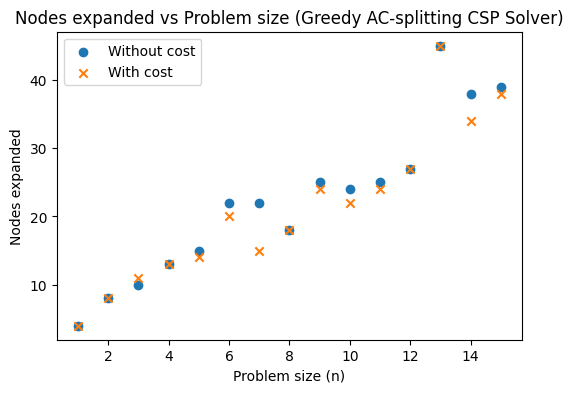

In [14]:
# Code for Question 3
# Place your code here

import matplotlib.pyplot as plt
import random

random.seed(10)
display = True

def generate_problem(n):
    """
    tasks = {t1:[duration, start-time, end-time], t2:[...], ..., tn:[...]}
    """
    problem = ''
    tasks = {}
    for i in range(n):
        duration = random.randint(1, 7)
        problem += f'task, t{str(i+1)} {duration}\n'
        tasks[f't{str(i+1)}'] = [duration]

    # generate a solution to ensure solvability
    for t in tasks.keys():
        assigned_time = random.randint(0,39)
        while (assigned_time%8) + tasks[t][0] >= 8:  # ensure enough time left in the day
            assigned_time = random.randint(0,39)
        tasks[t].append(assigned_time) # start-time
        tasks[t].append(assigned_time + tasks[t][0]) # end-time

    # print('allocated valid solution')
    # for k, v in tasks.items():
    #     print(k, v)
    # print()

    # binary contraints t1 before t2
    added_edges = set()
    tasks_sorted_starts = sorted(tasks.keys(), key=lambda t: tasks[t][1])
    # print(tasks_sorted_starts)
    no_binary_const = random.randint(0,2*n)
    # print(f'attempt to make {no_binary_const} t1 before t2 constraints')
    for constraint in range(no_binary_const):
        t_1 = random.choice(tasks_sorted_starts)
        # find for t2 where sample where t1 ends before t2 starts
        i = 0
        while i < n and tasks[t_1][2] >= tasks[tasks_sorted_starts[i]][1]:
            # print(t_1, 'ends', tasks[t_1][2], tasks_sorted_starts[i] ,'starts', tasks[tasks_sorted_starts[i]][1])
            i += 1
        if i < n:       
            t_2 = random.choice(tasks_sorted_starts[i:])
            # print(tasks_sorted_starts[i:], t_2)
            if (t_1, t_2) not in added_edges:
                problem += f'constraint, {t_1} before {t_2}\n'
                added_edges.add((t_1, t_2))
        else: 
            pass # no t2 exists, give up
            # print('no t2 exists\n\n\n')

    # hard domain contraints
    for t, v in tasks.items():
        dur, start, end = v[0], v[1], v[2]
        # print(t)
        if random.random() < 0.1:
            day_time = Day_Time().week_hour_number_to_day_time(start)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} {day}\n'
        if random.random() < 0.1:
            day_time = Day_Time().week_hour_number_to_day_time(start)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} {time}\n'
        if random.random() < 0.1:
            start_t = random.randint(start,39)
            day_time = Day_Time().week_hour_number_to_day_time(start_t)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} starts-before {day} {time}\n' # hard
        if random.random() < 0.1:
            start_t = random.randint(0, start)
            day_time = Day_Time().week_hour_number_to_day_time(start_t)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} starts-after {day} {time}\n' # hard
        if random.random() < 0.1:
            end_t = random.randint(end, 39)
            day_time = Day_Time().week_hour_number_to_day_time(end_t)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} ends-before {day} {time}\n' # hard
        if random.random() < 0.1:
            end_t = random.randint(0, end)
            day_time = Day_Time().week_hour_number_to_day_time(end_t)
            day, time = day_time.split()[0], day_time.split()[1]
            problem += f'domain, {t} ends-after {day} {time}\n' # hard
            

        # soft deadline contraint 
    for t, v in tasks.items():  # every task given 1 soft constraint
        day_time = Day_Time().week_hour_number_to_day_time(random.randint(0,39))
        day, time = day_time.split()[0], day_time.split()[1]
        cost = random.randint(1,10)
        problem += f'domain, {t} ends-by {day} {time} {cost}\n' # soft
    
    
    return problem

# n = random.randint(4,12)
    
spec = generate_problem(15)

# solver without cost
print('running without cost')
original_calc_cost = CSP_with_Cost.calculate_cost
CSP_with_Cost.calculate_cost = lambda self: 0  # eliminate calculate_cost() function

csp_no_cost = create_CSP_from_spec(spec)
solver_nc = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_no_cost))
test_csp_solver(solver_nc)
# solver_nc.search()
nodes_no_cost = num_expanded # global var from DFS solver WRONG

# solver WITH cost
print('running with cost')
CSP_with_Cost.calculate_cost = original_calc_cost  # restore

csp_cost = create_CSP_from_spec(spec)
solver_c = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_cost))
test_csp_solver(solver_c)
# solver_c.search()
nodes_with_cost = num_expanded # global var from DFS solver WRONG

#PLOTTING
ns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
no_cost = [4,8,10,13,15,22,22,18,25,24,25,27,45,38,39]
with_cost = [4,8,11,13,14,20,15,18,24,22,24,27,45,34,38]

plt.figure(figsize=(6,4))
plt.scatter(ns, no_cost, label="Without cost", marker="o")
plt.scatter(ns, with_cost, label="With cost", marker="x")
plt.xlabel("Problem size (n)")
plt.ylabel("Nodes expanded")
plt.title("Nodes expanded vs Problem size (Greedy AC-splitting CSP Solver)")
plt.legend()
plt.show()

__Answers for Question 3__

Implementing the cost function guarantes optimality, as soft cost is an admissable monotonic heuristic, meaning nodes are expanded in non-decreasing order of estimated cost, guaranteeing that the first goal dequeued is the minimum-cost solution. In contrast, the solver without the cost heuristic, expands the children in an arbitrary order produced by Python’s unordered set partitioning. In practice the solver will take the 'left' partition of the split often taking the set of earlier times coincidentally leading to a low-cost solution, but this is not guaranteed. 

The implementation of the cost function will have little effect on the number of nodes expanded, rather the solver will take the minimum cost path leading to the optimal goal state, rather than some arbitrary goal state. There will be some additional overhead to implement calculate_cost(), with time complexity O(n) per node. However this will be negligible compared to potential costs to ensure arc consistency, which will be O(n·d<sup>2</sup>) under the assumption of one binary contraint per task. Thus, we expect little to no change in node expansion count, only in the order in which nodes are explored and the guarantee of optimality.

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

task, t1 5
task, t2 1
task, t3 4
task, t4 4
task, t5 5
task, t6 1
task, t7 2
task, t8 4
task, t9 7
task, t10 4
task, t11 7
task, t12 3
task, t13 6
task, t14 7
task, t15 2
task, t16 1
task, t17 5
task, t18 4
task, t19 3
task, t20 1
task, t21 2
task, t22 6
task, t23 3
task, t24 1
task, t25 4
constraint, t25 before t4
constraint, t19 before t5
constraint, t24 before t16
constraint, t23 before t15
constraint, t23 before t4
constraint, t22 before t7
domain, t1 9am
domain, t1 ends-after mon 4pm
domain, t5 11am
domain, t6 wed
domain, t9 9am
domain, t10 thu
domain, t11 mon
domain, t15 ends-after thu 12pm
domain, t16 ends-before fri 4pm
domain, t19 ends-after tue 12pm
domain, t21 thu
domain, t21 starts-after tue 11am
domain, t21 ends-after tue 1pm
domain, t22 ends-before thu 9am
domain, t24 10am
domain, t25 ends-before fri 2pm
domain, t1 ends-by mon 11am 10
domain, t2 ends-by wed 4pm 7
domain, t3 ends-by wed 1pm 10
domain, t4 ends-by tue 11am 3
domain, t5 ends-by mon 4pm 10
domain, t6 ends-by w

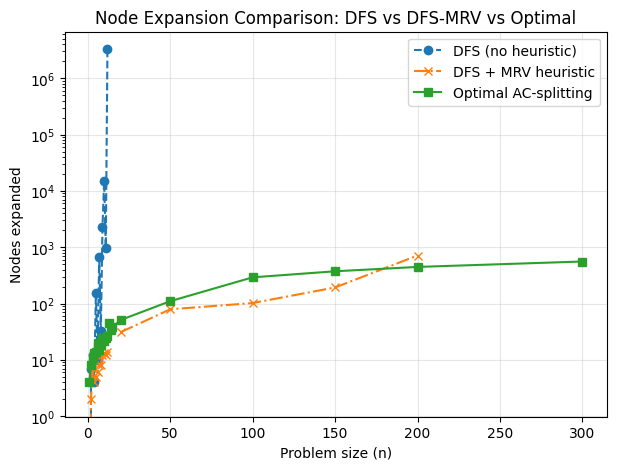

In [15]:
# Code for Question 4
# Place your code here

display = False

random.seed(10)

spec = generate_problem(25)
csp_problem = create_CSP_from_spec(spec)

# test_dfs_solver(csp_problem)    
# dfs_solve_all(csp_problem)

test_mrv_dfs_solver(csp_problem)
# mrv_dfs_solve_all(csp_problem)

csp_problem = create_CSP_from_spec(spec)
solver_c = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver_c)


ns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,50,100,150,200,300] 
dfs = [0,7,12,4,157,10,681,33,2265,14847,982,3282542,None,None,None,None,None,None,None,None,None]
mrv_dfs = [0,2,7,4,5,6,8,8,12,13,12,14,None,None,None,31,79,102,193,713,None]
optimal = [4,8,11,13,14,20,15,18,24,22,24,27,45,34,38,51,110,292,374,447,558]

plt.figure(figsize=(7,5))

plt.plot(ns, dfs, marker="o", linestyle="--", label="DFS (no heuristic)")
plt.plot(ns, mrv_dfs, marker="x", linestyle="-.", label="DFS + MRV heuristic")
plt.plot(ns, optimal, marker="s", linestyle="-", label="Optimal AC-splitting")

plt.xlabel("Problem size (n)")
plt.ylabel("Nodes expanded")
plt.title("Node Expansion Comparison: DFS vs DFS-MRV vs Optimal")
plt.yscale("log")  # OPTIONAL - highly recommended since DFS will spike hard
plt.legend()
plt.grid(alpha=0.3)
plt.show()


example_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
task, t3 3
task, t4 2
task, t5 1
# two binary constraints
constraint, t5 before t4
constraint, t5 before t3
constraint, t5 after t2
constraint, t5 after t1
constraint, t5 same-day t2
# domain constraint
domain, t5 wed
# soft deadlines
"""
# csp_problem = create_CSP_from_spec(example_spec)
# test_mrv_dfs_solver(example_spec)
# test_dfs_solver(csp_problem)





__Answers for Question 4__

If you want to submit additional code, put this at the end of the notebook. Here just give the answers (including plots or tables).

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)

The worst case time complexity of both DFS solver with and without heuristic is O(d<sup>n</sup>) as stated in Q1. Space complexity is max size of the recurisve stack O(n)

- What are the properties of the search algorithms (completeness, optimality)? (1 mark)

Generally, DFS solvers are incomplete as they can get caught in cycles or down a path of infinite depth. However, in this context, the search space is acyclic and finite. The solver will eventually explore the solution making DFS complete, however the solution may never be found for n>12 where exploring the entire search space isn't feasable due to computational cost. Adding the heuristic makes these larger problems much cheaper, although in the worst case, time complexity remains the same (evenly bound variables). 

Neither DFS or DFS with added heuristic is optimal. Both will terminate at the first goal state with all hard constraints satisfied with no regard for cost. The heuristic only makes the search faster. 

- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)

example_spec = """
task, t1 3
task, t2 4
task, t3 3
task, t4 2
task, t5 1
constraint, t5 before t4
constraint, t5 before t3
constraint, t5 after t2
constraint, t5 after t1
constraint, t5 same-day t2
domain, t5 wed
"""

Problems with a few highly constrainted variables and large n will be much easier to solve. The heuristic will satisfy those with the smallest domain first, which tend to be the most constrained. By forcing assignment to to difficult variables first, paths are pruned much earlier instead of getting lost deep in the tree exploring failing partial assignments of highly constrained variables. This example specifically the dfs solver 'Nodes expanded to reach solution: 51968' whereas added heuristic 'Nodes expanded to reach solution: 9'
  
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)

Regarding runtime, the DFS without heuristic performs the worst of the 3 solvers, and begins to fail reliably at n>12, subbing into time complexity O(d<sup>n</sup>) becomes O(40<sup>12</sup>), this is an extremely large number and unlikely to be found by the solver in the worst case. DFS with heuristic performed similarly to the optimal solution of domain splitting with arc consistency and added cost heuristic. These were both found to take longer than 10 sec at fail at n = ~200. Performance of these solvers is subject to change based on the number and distribution of constraints however. 

*Data on number of nodes/paths expanded (as a proxy for runtime), was collected and graphed in the code block above. Raw data used is provided below.

| n   | DFS Expanded | MRV+DFS Expanded | Optimal (Cost) |
|-----|-------------|------------------|----------------|
| 1   | 0           | 0                | 4              |
| 2   | 7           | 2                | 8              |
| 3   | 12          | 7                | 11             |
| 4   | 4           | 4                | 13             |
| 5   | 157         | 5                | 14             |
| 6   | 10          | 6                | 20             |
| 7   | 681         | 8                | 15             |
| 8   | 33          | 8                | 18             |
| 9   | 2265        | 12               | 24             |
| 10  | 14847       | 13               | 22             |
| 11  | 982         | 12               | 24             |
| 12  | 3282542     | 14               | 27             |
| 13  | –           | –                | 45             |
| 14  | –           | –                | 34             |
| 15  | –           | –                | 38             |
| 20  | –           | 31               | 51             |
| 50  | –           | 79               | 110            |
| 100 | –           | 102              | 292            |
| 150 | –           | 193              | 374            |
| 200 | –           | 713              | 447            |
| 300 | –           | –                | 558            |

Regarding the optimality of the solvers, dfs with or without heuristic was found to be significantly worse than the optimal solution, as it is not guaranteed to find the minimum cost solution. Both DFS solvers will submit the first goal state found where all hard constraints are satisfied. Added heuristic only guides finding a solution faster but does not influence whether the solution will be more optimal. 

- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

Data below gained from manually reading 'Nodes expanded to reach solution: ' with random.seed(10) from generate_problem(n) with orderred n range 1-12:

dfs_solver without heuristic will very likely expand many more nodes. It is worth noting that in a few cases, the dfs solver may get lucky and assign more highly constrained tasks first and perform similarly to dfs + heuristic. Overall on average, DFS-MRV consistently expands far fewer nodes across problem sizes, confirming that MRV improves efficiency by prioritising the most constrained variables first.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver as heuristics to guide the search. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the cost of violating the soft deadline constraint (if any) associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose a variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [16]:
# Code for Question 5
# Place a copy of your code here and run it in the relevant cell

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in sorted(domains[var]):  # SORTED - explore earlier times first before later times
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])


def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol, num_expanded  # CHANGE HERE ONLY - return num_expanded for evaluation

def get_var_order(csp):
    var_costs = {}
    for var, cost_func in csp.cost_functions.items():
        earliest = min(csp.domains[var])
        min_cost = cost_func[0](earliest, csp.soft_day_time[var], csp.durations[var], csp.soft_costs[var])
        var_costs[var] = min_cost
    # print(var_costs)
    return sorted(var_costs, key=var_costs.get)

def solution_cost(csp, assignment):
    total = 0
    for var, start_time in assignment.items():
        cost_fn = csp.cost_functions[var][0]
        total += cost_fn(start_time, csp.soft_day_time[var], csp.durations[var], csp.soft_costs[var])
    return total


random.seed(15)  # 9 n=5 was good, 15 n=7 diff cost and 
spec = generate_problem(7)
csp_problem = create_CSP_from_spec(spec)
var_order = get_var_order(csp_problem)
sol_heur, nodes_h = dfs_solve1(csp_problem, var_order)  # pass in orderred variables as argument
print("Heuristic DFS cost:", solution_cost(csp_problem, sol_heur))

csp_problem = create_CSP_from_spec(spec)
sol_plain, nodes_p = dfs_solve1(csp_problem)
print("Plain DFS cost:", solution_cost(csp_problem, sol_plain))


task, t1 2
task, t2 1
task, t3 5
task, t4 6
task, t5 1
task, t6 2
task, t7 2
constraint, t3 before t4
constraint, t2 before t6
constraint, t4 before t5
constraint, t2 before t5
constraint, t7 before t4
constraint, t7 before t6
constraint, t7 before t5
constraint, t6 before t5
domain, t1 ends-after mon 12pm
domain, t2 ends-before fri 4pm
domain, t3 ends-before wed 4pm
domain, t4 ends-after tue 9am
domain, t6 starts-before wed 10am
domain, t7 starts-before tue 3pm
domain, t7 ends-before thu 2pm
domain, t1 ends-by fri 2pm 8
domain, t2 ends-by wed 9am 2
domain, t3 ends-by fri 4pm 1
domain, t4 ends-by mon 12pm 6
domain, t5 ends-by thu 9am 7
domain, t6 ends-by wed 3pm 1
domain, t7 ends-by fri 4pm 5
Nodes expanded to reach solution: 1874
Heuristic DFS cost: 162
task, t1 2
task, t2 1
task, t3 5
task, t4 6
task, t5 1
task, t6 2
task, t7 2
constraint, t3 before t4
constraint, t2 before t6
constraint, t4 before t5
constraint, t2 before t5
constraint, t7 before t4
constraint, t7 before t6
constrai

Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solution: 0
Nodes expanded to reach solu

Text(0.5, 1.0, 'Solution Cost vs n')

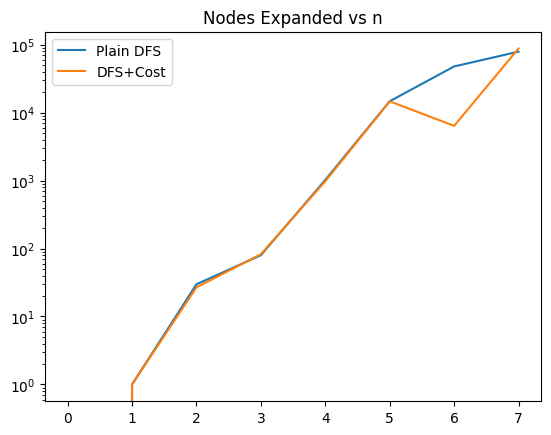

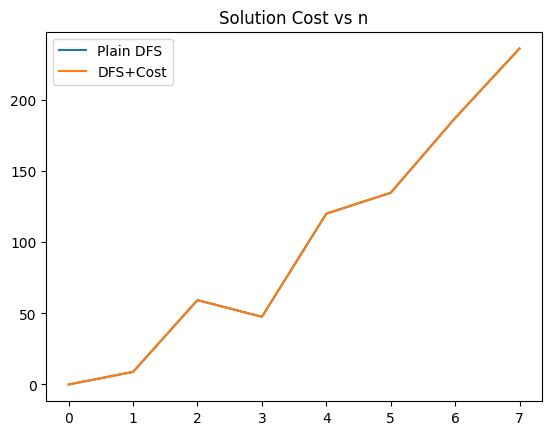

In [17]:
# note THIS CODE BLOCK TAKES A WHILE TO GENERATE AVERAGES - MAY TESTS RUN ~ 5 min

import random
results = []

def dfs_solve1(csp, var_order=None):
    global num_expanded
    num_expanded = 0
    if var_order == None:
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol, num_expanded   # need to return num expanded here

for n in range(8):
    costs_plain = []
    costs_heur = []
    nodes_plain = []
    nodes_heur = []

    for trial in range(20):  # change range() here to run less trials - speed up
        random.seed(trial)

        spec = generate_problem(n)
        csp1 = create_CSP_from_spec(spec)
        sol_p, nodes_p = dfs_solve1(csp1)
        cost_p = solution_cost(csp1, sol_p)

        csp2 = create_CSP_from_spec(spec)
        var_order = get_var_order(csp2)
        sol_h, nodes_h = dfs_solve1(csp2, var_order)
        cost_h = solution_cost(csp2, sol_h)

        costs_plain.append(cost_p)
        costs_heur.append(cost_h)
        nodes_plain.append(nodes_p)
        nodes_heur.append(nodes_h)

    results.append({
        "n": n,
        "avg_nodes_plain": sum(nodes_plain) / len(nodes_plain),
        "avg_nodes_heur": sum(nodes_heur) / len(nodes_heur),
        "avg_cost_plain": sum(costs_plain) / len(costs_plain),
        "avg_cost_heur": sum(costs_heur) / len(costs_heur),
    })

print(results)

ns = [r["n"] for r in results]
nodes_plain = [r["avg_nodes_plain"] for r in results]
nodes_heur = [r["avg_nodes_heur"] for r in results]
cost_plain = [r["avg_cost_plain"] for r in results]
cost_heur = [r["avg_cost_heur"] for r in results]

plt.figure()
plt.plot(ns, nodes_plain, label="Plain DFS")
plt.plot(ns, nodes_heur, label="DFS+Cost")
plt.yscale("log")
plt.legend()
plt.title("Nodes Expanded vs n")

plt.figure()
plt.plot(ns, cost_plain, label="Plain DFS")
plt.plot(ns, cost_heur, label="DFS+Cost")
plt.legend()
plt.title("Solution Cost vs n")

__Answers for Question 5__

- Empirically compare the performance of DFS with and without these heuristics (2 marks)

*Refer to graph generated at the bottom of the above code for plotting and empirical comparison of methods. 

For DFS with cost heuristic, variables are ordered once at the root by their minimum soft-deadline penalty. This approximates ‘choose lowest-cost variable first’ without dynamically recomputing at each depth. This is safe as no domain shrinking occurs after the starting state prunes domains for unary constraints, so the minimum cost orderring will remain the same throughout the dfs_solver. 

Empirically, the optimality of the goal state with ordering by min cost variables first is very similar to plain DFS across all tested instances. While low cost variables are allocated first, this has the tradeoff that variables with higher costs are likely to be allocated later, incur more conflicts, and be allocated a worse time with a larger cost.

Additionally, the performance on average was found to be slightly poorer when averaged across trials. More constrained nodes are more likely to incur a higher cost and be allocated last, deep in the recursion tree. Rather than conflicing domains being pruned higher and more efficiently. This results in the opposite effect of the MRV heuristic which forces highly constrained variables to be satisfied earlier, resulting in large performance gains. 

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for fuzzy scheduling CSPs.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

In [18]:
# Code for Question 6
# Place a copy of your code here and run it in the relevant cell
Con_solver.max_display_level = 2
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 1


def partition_domain_k(dom, k):
    # Ensure a deterministic split into k (nearly) equal non-empty sets
    L = sorted(set(dom))
    n = len(L)
    parts = []
    for i in range(k):
        a = (i*n)//k
        b = ((i+1)*n)//k
        chunk = set(L[a:b])
        if chunk:
            parts.append(chunk)
    return parts


class Search_with_AC_from_Cost_CSP_K(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp, k=2):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp
        self.k = k

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1)
        if var:
            parts = partition_domain_k(node.domains[var], self.k)  # list[set]
            self.display(2, "Splitting", var, "into", parts)
            print('splitting', var, 'into', parts)
            to_do = self.cons.new_to_do(var, None)
            for dom in parts:
                newdoms = node.domains | {var: dom}        # overwrite var’s domain
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2, "...", var, "in", dom, "has no solution")
        return neighs

    
    def heuristic(self, n):
        return n.cost

random.seed(9)
spec = generate_problem(100)
for k in range(2, 7):
    print('\n\n', 'k =', k, '\n\n')
    csp_problem = create_CSP_from_spec(spec)
    solver_k3 = GreedySearcher(Search_with_AC_from_Cost_CSP_K(csp_problem, k))
    test_csp_solver(solver_k3)





 k = 2 


task, t1 4
task, t2 5
task, t3 3
task, t4 3
task, t5 2
task, t6 2
task, t7 7
task, t8 6
task, t9 1
task, t10 3
task, t11 5
task, t12 4
task, t13 5
task, t14 1
task, t15 3
task, t16 5
task, t17 5
task, t18 6
task, t19 1
task, t20 6
task, t21 4
task, t22 2
task, t23 6
task, t24 4
task, t25 6
task, t26 4
task, t27 2
task, t28 2
task, t29 2
task, t30 1
task, t31 1
task, t32 2
task, t33 5
task, t34 7
task, t35 5
task, t36 1
task, t37 7
task, t38 6
task, t39 4
task, t40 7
task, t41 6
task, t42 1
task, t43 3
task, t44 2
task, t45 6
task, t46 2
task, t47 6
task, t48 7
task, t49 4
task, t50 1
task, t51 7
task, t52 3
task, t53 2
task, t54 4
task, t55 3
task, t56 3
task, t57 7
task, t58 1
task, t59 2
task, t60 6
task, t61 1
task, t62 4
task, t63 1
task, t64 4
task, t65 7
task, t66 4
task, t67 2
task, t68 1
task, t69 2
task, t70 4
task, t71 6
task, t72 7
task, t73 1
task, t74 5
task, t75 1
task, t76 1
task, t77 7
task, t78 5
task, t79 2
task, t80 7
task, t81 2
task, t82 3
task, t83 1
t

__Answers for Question 6__

- Modify the CSP solver to use the list of k partitions and evaluate the performance of the solver using the above metric for a range of values of k (2 marks)

Partitioning the same problem into a range of k between 2 and 10 yields the same cost. This is because more partitions still maintain the optimality of the solver. As the monotonic cost function and greedy best-first expansion order are preserved.

The number of paths expanded generally reduces the greater the value of k. Although the branching factor means more states must be evaluated by the solver, domains are shrunk faster, resulting in generally fewer nodes being expanded. This increased branching results in more nodes remaining on the frontier, so although less paths are expanded, a similar amount of nodes must still be evaluated by the solver. Additionally there is a greater memory cost associated with higher branching, as more nodes remain on the frontier enqueued in the priority queue per node popped. Additionally as the domain splits more aggressively, arc consistency applications per split might become slightly cheaper, having to check across a smaller domain space. More analysis beyond nodes expanded would be needed to evaluate the true runtime tradeoff. 

As Poole & Mackworth suggest, k = 2 strikes a balanced trade-off between domain reduction and branching overhead. Our results are consistent with this claim: while k > 2 sometimes reduced expansions, the added branching and memory pressure make it unclear that larger k provides a net benefit.